### 농구 선수의 게임 데이터를 활용한 포지션 예측을 위한 데이터 정제
NBA 농구 선수들의 기록을 데이터로 사용해서 특정 농구 선수의 포지션을 예측

In [1]:
# import from

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import folium
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

In [15]:
df = pd.read_csv('../Data/basketball.csv')
df.head()

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5


- pos : position (SG: Shooting Guard, C: Center)   
- 3P : 한 경기당 평균 3점 슛 성공 횟수   
- 2P : 2점      
- TRB : 한 경기당 평균 리바운드 성공 횟수 (리바운드 : 골대밑에서 튕겨나온거 잡아낸 횟수)   
- AST : 한 경기당 평균 어시스트 성공 횟수   
- STL : 한 경기당 평균 스틸 성공 횟수   
- BLK : 한 경기당 평균 블로킹 성공 횟수   

In [3]:
# 포지션별 수 파악
df.Pos.value_counts() #빈도수 보여주기

SG    50
C     50
Name: Pos, dtype: int64

### 포지션 별 내용
- C : center는 골대,포스트 근처에서 슛을 블로킹 하고, 리바운드 하며, 바깥으로 쳐내고, 골대 근처에서 2점슛으로 득점을 노리기도 함
- SG : Shooting Guard는 코트내에서 3점슛 등 장거리에서 슛을 해서 점수를 얻는 역활

### 스틸,2점슛 시각화

In [4]:
import seaborn as sns

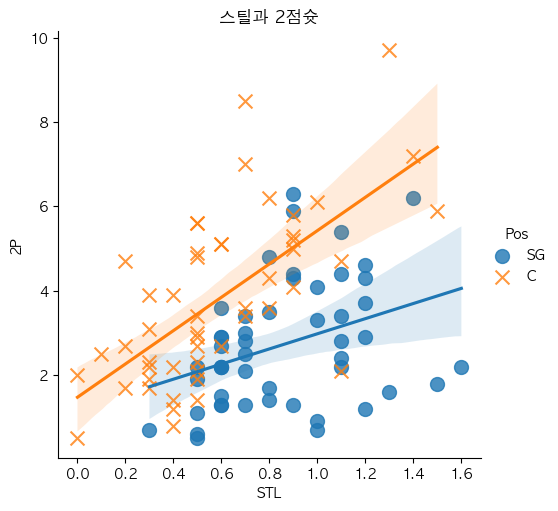

In [16]:
sns.lmplot(x='STL',y='2P',data=df,fit_reg=True, scatter_kws = {'s':100}, markers=['o','x'], hue='Pos') # scatter_kws좌표상의 점의 크기
plt.title('스틸과 2점슛')
plt.show()

이 scatter를 봐서는 스틸과 2점슛으로 sg와 c 를 나누기는 쉽지 않을듯
그럼 어시스트 2점슛은 어떨까?

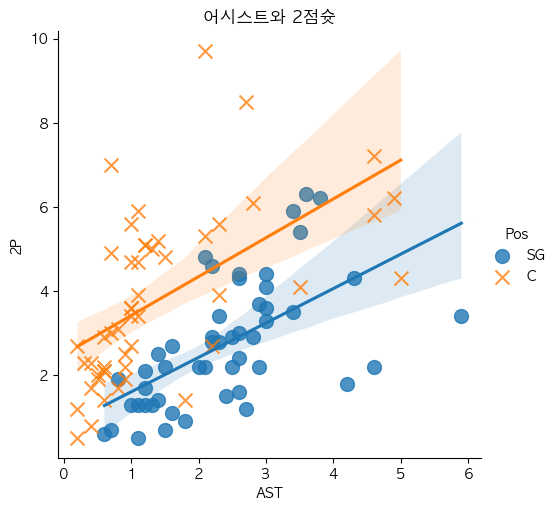

In [18]:
sns.lmplot(x='AST',y='2P',data=df,fit_reg=True, scatter_kws = {'s':100}, markers=['o','x'], hue='Pos') # scatter_kws좌표상의 점의 크기
plt.title('어시스트와 2점슛')
plt.show()

얘도 좀.... 다른것들도 계쏙 해보자
다음은 블록킹과 3점슛

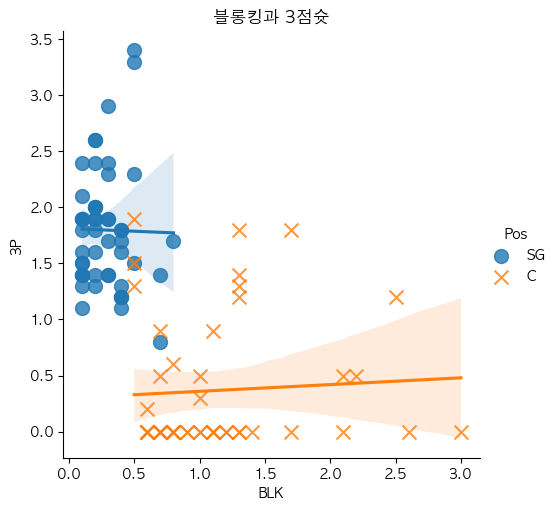

In [19]:
sns.lmplot(x='BLK',y='3P',data=df,fit_reg=True, scatter_kws = {'s':100}, markers=['o','x'], hue='Pos') # scatter_kws좌표상의 점의 크기
plt.title('블롱킹과 3점슛')
plt.show()

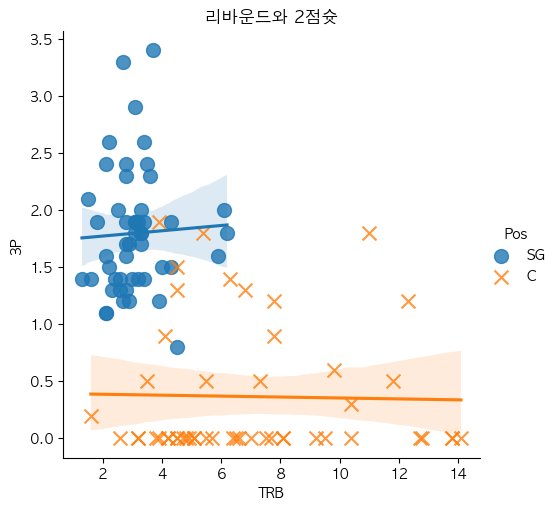

In [20]:
# 리바운드와 3점슛
sns.lmplot(x='TRB',y='3P',data=df,fit_reg=True, scatter_kws = {'s':100}, markers=['o','x'], hue='Pos') # scatter_kws좌표상의 점의 크기
plt.title('리바운드와 2점슛')
plt.show()

상관계수와는 상관없이 lmplot에 fit_reg로 회귀선이 수평이 되어 있는 것이 쓸만하다

In [9]:
# 난 걍 상관계수 쳐볼련다 ...
df.corr()

,3P,2P,TRB,AST,STL,BLK
3P,1.000000,-0.094914,-0.498036,0.485010,0.353517,-0.534588
2P,-0.094914,1.000000,0.680882,0.396094,0.353558,0.482056
TRB,-0.498036,0.680882,1.000000,0.026689,0.130441,0.707542
AST,0.485010,0.396094,0.026689,1.000000,0.640802,-0.148161
STL,0.353517,0.353558,0.130441,0.640802,1.000000,-0.138208
BLK,-0.534588,0.482056,0.707542,-0.148161,-0.138208,1.000000


### 데이터 다듬기
- 분별력이 없는 Feature를 데이터에서 제거
- 시각화를 통해 확인해 본 결과 2P, AST, STL은 분별력이 없다

In [10]:
df.drop(['2P','AST','STL'],axis=1, inplace=True)
df.head()

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


### 학습데이터와 검증데이터로 나누기

In [11]:
from sklearn.model_selection import train_test_split

# 다듬어 진 데이터에서 20%를 테스트데이터로 분류하기 (label 지금 없는거임!!)

train, test = train_test_split(df, test_size=0.2)

In [12]:
print(len(train))
print(len(test))
print(train.shape)
print(test.shape)

80
20
(80, 5)
(20, 5)


In [13]:
# save data
train.to_csv('../Data/basketball_train.csv', index=False)
test.to_csv('../Data/basketball_test.csv', index=False)